### Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display
import tabulate, tqdm, warnings

import torch

### Dataset Creation

In [2]:
np.random.seed(45)
num_samples = 40
    
# Generate data
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3*x1 + 4
eps = np.random.randn(num_samples)
y = f_x + eps

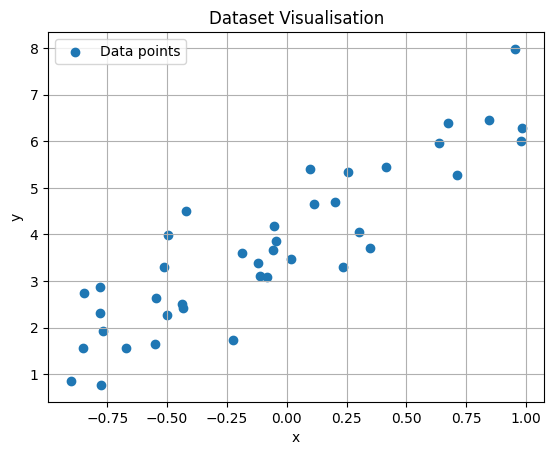

In [3]:
plt.scatter(x1, y, label = "Data points")
plt.title("Dataset Visualisation")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
# plt.plot([-0.75, 1], [1, 6.5], color = 'r', label = "Estimated Best fit line")
plt.legend()
plt.show()

### Task 1a

Use ```torch.autograd``` to find the true gradient on the above dataset using linear regression (in the form $\theta_1x + \theta_0$) for any given values of $(\theta_0,\theta_1)$. **[1 mark]**

In [4]:
# Converting to numpy arrays to tensors 
x1_tensor = torch.autograd.Variable(torch.from_numpy(x1), requires_grad = True)
y_tensor = torch.autograd.Variable(torch.from_numpy(y), requires_grad = True)

In [5]:
def model_prediction(x, theta1, theta0):
    """
    Returns: 
    Predictions made by the line theta1*x + theta0 on the given input array x
    """
    return theta1*x + theta0

In [6]:
def mse_loss(y_pred, y_true):
    return ((y_true - y_pred)**2).mean()

In [7]:
# you may change the values of theta1 and theta0
theta1 = torch.tensor([13.0], requires_grad = True)
theta0 = torch.tensor([2.0], requires_grad = True)

In [8]:
y_pred = model_prediction(x1_tensor, theta1, theta0)

In [9]:
loss = mse_loss(y_pred, y_tensor)

In [10]:
loss.backward()

In [11]:
print(f"Gradient of theta0: {theta0.grad.item()}")
print(f"Gradient of theta1: {theta1.grad.item()}")

Gradient of theta0: -5.649004936218262
Gradient of theta1: 6.847843647003174


### Task 1b
Using the same $(\theta_0,\theta_1)$ as above, calculate the stochastic gradient for all points in the dataset. Then, find the average of all those gradients and show that the stochastic gradient is a good estimate of the true gradient.  **[1 mark]**

In [12]:
cost = 0
stochastic_grad_theta0 = []
stochastic_grad_theta1 = []

In [13]:
for x_sample, y_sample in zip(list(x1), list(y)):
    x_sample_tensor = torch.tensor(x_sample, requires_grad = False)
    y_sample_tensor = torch.tensor(y_sample, requires_grad = False)
    theta1_tensor = torch.tensor(13.0, requires_grad = True)
    theta0_tensor = torch.tensor(2.0, requires_grad = True)
    model_prediction = theta1_tensor*x_sample + theta0_tensor
    loss = mse_loss(model_prediction, y_sample_tensor)
    loss.backward()
    stochastic_grad_theta0.append(theta0_tensor.grad)
    stochastic_grad_theta1.append(theta1_tensor.grad)
    del loss

In [14]:
print(np.mean(stochastic_grad_theta0))
print(np.mean(stochastic_grad_theta1))

-5.649005
6.847844


In [15]:
data = [["METHOD", "Theta0 Gradient", "Theta1 Gradient"],
    ["Stochastic Gradient Descent", np.mean(stochastic_grad_theta0), np.mean(stochastic_grad_theta1)],
    ["True Gradient", theta0.grad.item(), theta1.grad.item()]]

print(tabulate.tabulate(data, headers="firstrow", tablefmt="grid"))

+-----------------------------+-------------------+-------------------+
| METHOD                      |   Theta0 Gradient |   Theta1 Gradient |
+=============================+===================+===================+
| Stochastic Gradient Descent |            -5.649 |           6.84784 |
+-----------------------------+-------------------+-------------------+
| True Gradient               |            -5.649 |           6.84784 |
+-----------------------------+-------------------+-------------------+


Since, the value of gradients obtained by Stochastic Gradient Descent's average and that of true gradient are almost same, we can say that Stochastic Gradient Descent is a good estimator of true gradient

### Task 1c
Implement full-batch, mini-batch and stochastic gradient descent. Calculate the average number of iterations required for each method to get sufficiently close to the optimal solution, where "sufficiently close" means within a distance of $\epsilon$ (or $\epsilon$-neighborhood)  from the minimum value of the loss function. Visualize the convergence process for 15 epochs. Choose $\epsilon = 0.001$ for convergence criteria. Which optimization process takes a larger number of epochs to converge, and why? Show the contour plots for different epochs (or show an animation/GIF) for visualisation of optimisation process. Also, make a plot for Loss v/s epochs for all the methods. **[2 marks]**

##### Creating a random dataset of 40 points

In [16]:
np.random.seed(45)
num_samples = 40 #you can use more samples but that would lead to significantly more compute in executing the notebook

# Generate data
x_new = np.random.uniform(-1, 1, num_samples)
f_x = 3*x_new + 4
eps = np.random.randn(num_samples)
y = f_x + eps

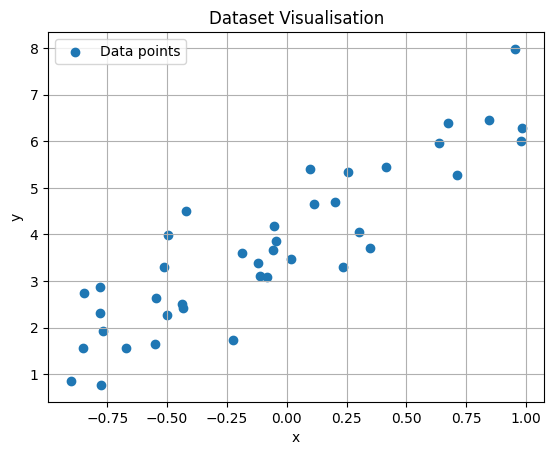

In [17]:
plt.scatter(x_new, y, label = "Data points")
plt.title("Dataset Visualisation")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
# plt.plot([-0.75, 1], [1, 6.5], color = 'r', label = "Estimated Best fit line")
plt.legend()
plt.show()

In [18]:
x_tensor = torch.tensor(x_new, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Add a batch dimension for compatibility
x_tensor = x_tensor.view(-1, 1)
y_tensor = y_tensor.view(-1, 1)

#### Helper functions

In [19]:
def linear_model_prediction(x, parameters):
    bias, weight = parameters
    return bias + weight * x

def mse_loss(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)

In [20]:

def normal_equation_solver(x_tensor, y_tensor):
    """
    Computes the optimal value of parameters using the normal equation of gradient descent optimization
    """
    # x_tensor = x_tensor.view(-1, 1)  
    # y_tensor = y_tensor.view(-1, 1)  

    # Adding a bias term (intercept) to x_tensor
    x_tensor = torch.cat((torch.ones(x_tensor.size(0), 1), x_tensor), dim=1)  # Add bias term
    print(type(x_tensor))
    # Calculate optimal parameters using the Normal Equation
    theta_optimal = torch.linalg.inv(x_tensor.T @ x_tensor) @ (x_tensor.T @ y_tensor)
    
    return theta_optimal

#### Full Batch Gradient Descent

In [21]:
def full_batch_gradient_descent(x, y, epochs=15, learning_rate=0.001, epsilon=0.001, model_prediction = model_prediction, loss_func = mse_loss, num_parameters = "given", verbose = 1):
    """
    Perform full-batch gradient descent to minimize the loss function.
    Args:
    - x, y --> must be torch.tensors
    
    Returns:
    - parameters --> tensor contatining the optimised parameters 
    - loss_history --> array containing cost after individual epochs
    - n_iterations --> number of iterations
    """
    if num_parameters == "given": # had to add this to get better contour plots
        parameters = torch.nn.Parameter(torch.tensor([-2.0, 2.0], dtype=torch.float32))
    else:
        parameters = torch.nn.Parameter(torch.randn(num_parameters , dtype=torch.float32))
        
    loss_history = []
    param_history = []
    parameters.requires_grad_(True)
    n_iterations = 0

    theta_optimal = normal_equation_solver(x, y).view(-1)
    
    for epoch in range(epochs):
        n_iterations += 1
        
        if epoch > 0:
            parameters.grad.zero_()      
        
        # Computing model predictions and loss based on those predictions
        y_pred = model_prediction(x, parameters)
        loss = loss_func(y, y_pred)
        loss_history.append(loss.item())
        
        # Backpropagation
        loss.backward()
        
        # Updateign the parameters
        with torch.no_grad():
            # print(parameters)
            # print(parameters.grad)
            parameters -= learning_rate * parameters.grad
    
        param_history.append([parameters[i].item() for i in range(len(parameters))])
        param_diff = torch.norm(parameters - theta_optimal)
        if verbose:
            print(f"Epoch: {epoch + 1} ---> Loss = {loss}")
            # print(f"Parameter difference: {param_diff.item()}")
        # print(parameters)
        
        # Convergence
        # print(f"Parameters: {parameters[0], parameters[1]}")
        # print(f"Optimal Theta: {theta_optimal}")
        # print(f"Parameters Gradient: {parameters.grad}")

        # print(f"Parameters shape: {parameters.shape}")
        # print(f"Optimal Theta shape: {theta_optimal.shape}")

        # print(torch.norm(parameters - theta_optimal))
        

        # print(param_diff.item() <= epsilon)
        if param_diff.item() <= epsilon:
            print(f"Convergence reached after {epoch + 1} epochs. Parameter difference: {param_diff.item()}")
            break

    return parameters, loss_history, n_iterations, epoch + 1, param_history

In [22]:
updated_parameters, loss_history, n_iterations, epoch, param_history = full_batch_gradient_descent(x_tensor, y_tensor, epochs = 100000, learning_rate = 0.001, epsilon = 0.001, model_prediction = linear_model_prediction, loss_func = mse_loss)

<class 'torch.Tensor'>
Epoch: 1 ---> Loss = 35.465885162353516
Epoch: 2 ---> Loss = 35.326786041259766
Epoch: 3 ---> Loss = 35.18824768066406
Epoch: 4 ---> Loss = 35.050270080566406
Epoch: 5 ---> Loss = 34.912841796875
Epoch: 6 ---> Loss = 34.775962829589844
Epoch: 7 ---> Loss = 34.63964080810547
Epoch: 8 ---> Loss = 34.503868103027344
Epoch: 9 ---> Loss = 34.3686408996582
Epoch: 10 ---> Loss = 34.23395538330078
Epoch: 11 ---> Loss = 34.09981155395508
Epoch: 12 ---> Loss = 33.966209411621094
Epoch: 13 ---> Loss = 33.83314514160156
Epoch: 14 ---> Loss = 33.70061492919922
Epoch: 15 ---> Loss = 33.5686149597168
Epoch: 16 ---> Loss = 33.43714904785156
Epoch: 17 ---> Loss = 33.30621337890625
Epoch: 18 ---> Loss = 33.175804138183594
Epoch: 19 ---> Loss = 33.04591369628906
Epoch: 20 ---> Loss = 32.91655349731445
Epoch: 21 ---> Loss = 32.78770446777344
Epoch: 22 ---> Loss = 32.65938186645508
Epoch: 23 ---> Loss = 32.53156661987305
Epoch: 24 ---> Loss = 32.404273986816406
Epoch: 25 ---> Loss = 

In [23]:
bias, weight = updated_parameters[0].item(), updated_parameters[1].item()

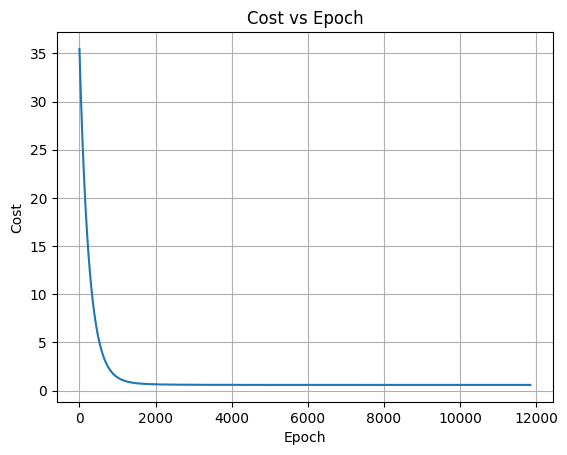

In [24]:
plt.plot(list(range(1, epoch + 1)), loss_history)
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Cost vs Epoch")
plt.show()

In [25]:
from sklearn.linear_model import LinearRegression

X = x_new.reshape(-1, 1)
y = y.reshape(-1, 1)
lr = LinearRegression()
lr.fit(X, y)

intercept = lr.intercept_[0]
slope = lr.coef_[0][0]

Text(0.5, 0.98, 'Gradient Descent')

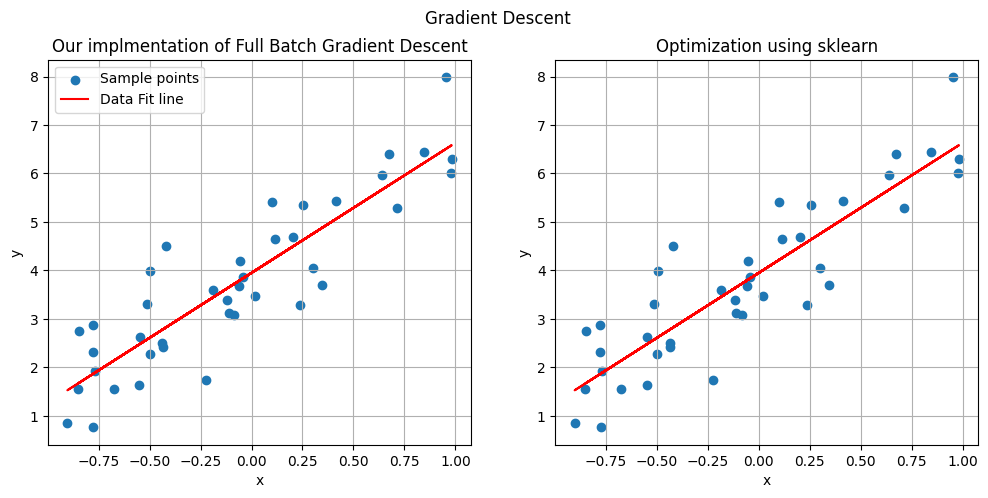

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Our plot
axs[0].scatter(x_new, y, label="Sample points")
axs[0].plot(x_new, x_new * weight + bias, label="Data Fit line", color='r')
axs[0].legend()
axs[0].grid(True)
axs[0].set_title('Our implementation of Full Batch Gradient Descent')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# sklearn
axs[1].scatter(x_new, y, label="Sample points")
axs[1].plot(x_new, slope * x_new + intercept, color='r', label="Fit line")
axs[1].grid(True)
axs[1].set_title('Optimization using sklearn')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.suptitle("Gradient Descent")

#### Stochastic Gradient Descent

In [27]:
def stochastic_batch_gradient_descent(x, y, epochs=15, learning_rate=0.01, epsilon=0.001, model_prediction = model_prediction, loss_func = mse_loss, num_parameters = 2, verbose = 1):
    """
    Perform full-batch gradient descent to minimize the loss function.
    Args:
    - x, y --> must be torch.tensors
    
    Returns:
    - parameters --> tensor containing the optimized parameters 
    - loss_history --> array of arrays containing loss over different iterations for that epoch
    - cost_history --> array containing avg cost over each epoch
    - n_iterations --> number of iterations
    """
    if num_parameters == "given":
        parameters = torch.nn.Parameter(torch.tensor([-3.0, 3.0], dtype=torch.float32))
    else:
        parameters = torch.nn.Parameter(torch.randn(num_parameters , dtype=torch.float32))
    loss_history = []
    cost_history = []
    param_history = []


    theta_optimal = normal_equation_solver(x, y).view(-1)

    # x = x[:int(1*len(x)/2)]
    # y = y[:int(1*len(y)/2)]
    # print(x)
    # print(y)
    
    parameters.requires_grad_(True)
    n_iterations = 0
    num_samples = len(x)
    
    for epoch in range(epochs):
        epoch_loss_history = []

        shuffled_indices = torch.randperm(num_samples)
        
        # if epoch > 0:
        #     parameters.grad.zero_()      

        for xi, yi in zip(x[shuffled_indices], y[shuffled_indices]):
            n_iterations += 1
            if parameters.grad is not None:
                parameters.grad.zero_()
            
            # Computing model predictions and loss based on those predictions
            y_pred = model_prediction(xi, parameters)
            loss = loss_func(yi, y_pred)
            # print(loss.item())
            epoch_loss_history.append(loss.item())
            
            # Backpropogation
            loss.backward()
            
            # Updating the parameters
            with torch.no_grad():
                # print(parameters)
                # print(parameters.grad)
                parameters -= learning_rate * parameters.grad
                
            # print(parameters)
        param_history.append([parameters[i].item() for i in range(len(parameters))])
        cost_history.append(sum(epoch_loss_history)/len(epoch_loss_history))
        param_diff = torch.norm(parameters - theta_optimal)
        
        if verbose:
            print(f"Epoch: {epoch + 1} ---> Average cost = {cost_history[-1]}")
            # print(f"Parameter difference: {param_diff.item()}")
            # print(epoch_loss_history)
            # print(cost_history)
        loss_history.append(epoch_loss_history)

        # Convergence
        # 
        # print(f"Optimal theta: {theta_optimal}")
        # print(param_diff.item() <= epsilon)
        if param_diff.item() <= epsilon:
            print(f"Convergence reached after {epoch + 1} epochs. Parameter difference: {param_diff.item()}")
            break

    return parameters, loss_history, n_iterations, cost_history, epoch+1, param_history

In [28]:
updated_parameters, loss_history, n_iterations, cost_history, epoch, param_history = stochastic_batch_gradient_descent(x_tensor, y_tensor, epochs = 3000, learning_rate = 0.001, epsilon = 0.001, model_prediction = linear_model_prediction, loss_func = mse_loss)

<class 'torch.Tensor'>
Epoch: 1 ---> Average cost = 15.65807918803912
Epoch: 2 ---> Average cost = 14.024446606944547
Epoch: 3 ---> Average cost = 12.604569557436822
Epoch: 4 ---> Average cost = 11.371056031645276
Epoch: 5 ---> Average cost = 10.296503630792722
Epoch: 6 ---> Average cost = 9.355205403108993
Epoch: 7 ---> Average cost = 8.529553056821168
Epoch: 8 ---> Average cost = 7.80354688083753
Epoch: 9 ---> Average cost = 7.165680034435354
Epoch: 10 ---> Average cost = 6.602922974949069
Epoch: 11 ---> Average cost = 6.103112144840997
Epoch: 12 ---> Average cost = 5.658269596699393
Epoch: 13 ---> Average cost = 5.262263962463476
Epoch: 14 ---> Average cost = 4.908633919557905
Epoch: 15 ---> Average cost = 4.591231516207335
Epoch: 16 ---> Average cost = 4.305384049721761
Epoch: 17 ---> Average cost = 4.047583144420059
Epoch: 18 ---> Average cost = 3.8143292194698004
Epoch: 19 ---> Average cost = 3.602254262333736
Epoch: 20 ---> Average cost = 3.409072546265088
Epoch: 21 ---> Average

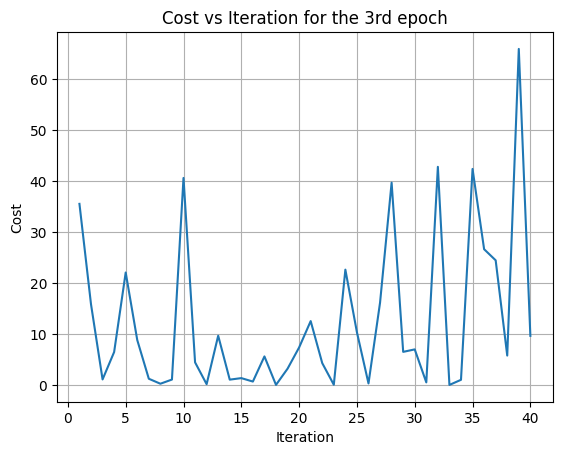

In [29]:
plt.plot(list(range(1, int(len(x_new))+1)), loss_history[2])
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost vs Iteration for the 3rd epoch")
plt.grid(True)
plt.show()

As we can see that the cost function is no longer monotonusly decreasing, this is becasue the loss no longer decomposes over the average but is rather dependent on the training example chosen

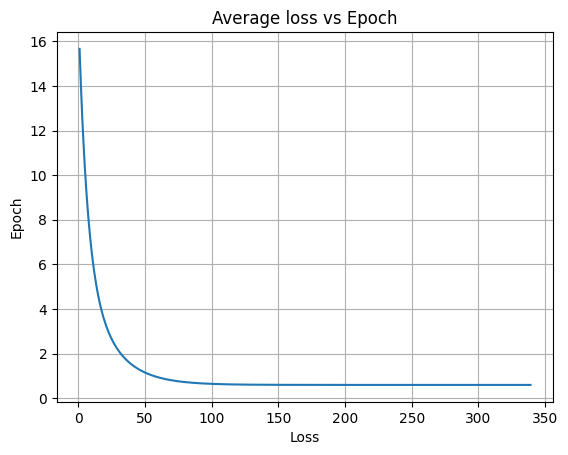

In [30]:
plt.plot(list(range(1,epoch+1)), cost_history)
plt.xlabel("Loss")
plt.ylabel("Epoch")
plt.title("Average loss vs Epoch")
plt.grid(True)
plt.show()

In [31]:
bias, weight = updated_parameters[0].item(), updated_parameters[1].item()

Text(0.5, 0.98, 'Stochastic Gradient Descent')

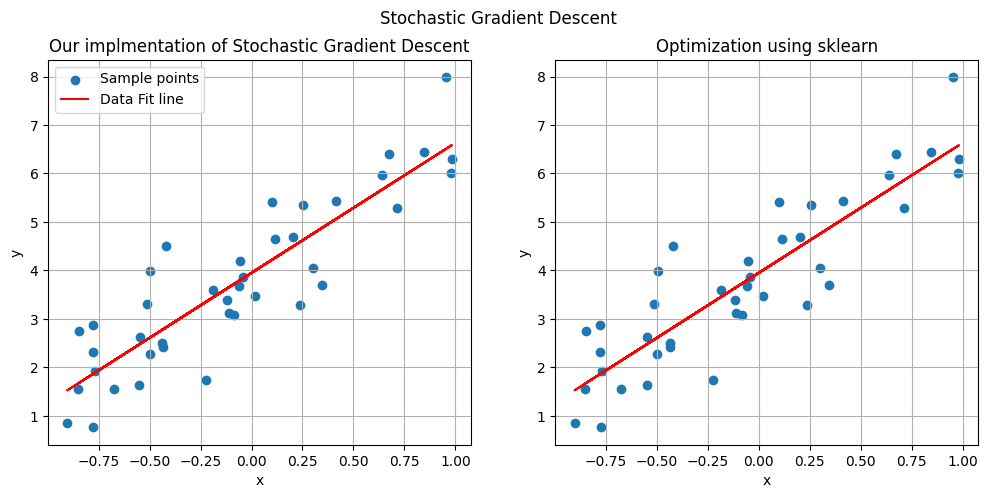

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Our plot for stochastic gradient descent
axs[0].scatter(x_new, y, label="Sample points")
axs[0].plot(x_new, x_new * weight + bias, label="Data Fit line", color='r')
axs[0].legend()
axs[0].grid(True)
axs[0].set_title('Our implementation of Stochastic Gradient Descent')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# sklearn
axs[1].scatter(x_new, y, label="Sample points")
axs[1].plot(x_new, slope * x_new + intercept, color='r', label="Fit line")
axs[1].grid(True)
axs[1].set_title('Optimization using sklearn')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.suptitle("Stochastic Gradient Descent")

#### Mini batch Gradient Descent

In [33]:
def mini_batch_gradient_descent(x, y, batch_size = 8, epochs=15, learning_rate=0.01, epsilon=0.001, model_prediction = model_prediction, loss_func = mse_loss, num_parameters = 2, verbose = 1):
    """
    Perform mini-batch gradient descent to minimize the loss function.
    Args:
    - x, y --> must be torch.tensors
    
    Returns:
    - parameters --> tensor containing the optimized parameters 
    - loss_history --> array of arrays containing loss over different iterations for that epoch
    - cost_history --> array containing avg cost over each epoch
    - n_iterations --> number of iterations
    """
    if num_parameters == "given":
        parameters = torch.nn.Parameter(torch.tensor([-2.0, 2.0], dtype=torch.float32))
    else:
        parameters = torch.nn.Parameter(torch.randn(num_parameters , dtype=torch.float32))
    loss_history = []
    param_history = []
    
    theta_optimal = normal_equation_solver(x, y).view(-1)

    parameters.requires_grad_(True)
    n_iterations = 0
    
    num_batches = len(x)//batch_size
    for epoch in range(epochs):
        shuffled_indices = torch.randperm(len(x))     
        epoch_loss_history = []
        
        for i in range(num_batches):
            batch_indices = shuffled_indices[i:i + batch_size]
            xi = x[batch_indices]
            yi = y[batch_indices]
            
            n_iterations += 1
            parameters.grad = None
            
            # Computing model predictions and loss based on those predictions
            y_pred = model_prediction(xi, parameters)
            loss = loss_func(yi, y_pred)
            
            # Backpropogation
            loss.backward()
            epoch_loss_history.append(loss.item())
            # Updating the parameters
            with torch.no_grad():
                parameters -= learning_rate * parameters.grad
            n_iterations += 1
                
        param_history.append([parameters[i].item() for i in range(len(parameters))])
        loss_history.append(sum(epoch_loss_history)/len(epoch_loss_history))

        param_diff = torch.norm(parameters - theta_optimal, 2)

        if verbose:
            print(f"Epoch: {epoch + 1} ---> Average cost = {loss_history[-1]}")
            # print(f"Parameter difference: {param_diff.item()}")

        # Convergence
        # print(f"Optimal theta: {theta_optimal}")
        # print(f"Parameters: {parameters}")
        # print(param_diff.item() <= epsilon)
        if param_diff.item() <= epsilon:
            print(f"Convergence reached after {epoch + 1} epochs. Parameter difference: {param_diff.item()}")
            break

    return parameters, loss_history, n_iterations, epoch+1, param_history

In [34]:
updated_parameters, loss_history, n_iterations, epoch, param_history = mini_batch_gradient_descent(x_tensor, y_tensor, epochs = 10000, learning_rate = 0.001, epsilon = 0.001, model_prediction = linear_model_prediction, loss_func = mse_loss)

<class 'torch.Tensor'>
Epoch: 1 ---> Average cost = 14.880154800415038
Epoch: 2 ---> Average cost = 11.013786506652831
Epoch: 3 ---> Average cost = 8.665415477752685
Epoch: 4 ---> Average cost = 10.507162284851074
Epoch: 5 ---> Average cost = 12.645628738403321
Epoch: 6 ---> Average cost = 11.416476058959962
Epoch: 7 ---> Average cost = 14.901819038391114
Epoch: 8 ---> Average cost = 10.428104591369628
Epoch: 9 ---> Average cost = 9.687071609497071
Epoch: 10 ---> Average cost = 10.558354949951172
Epoch: 11 ---> Average cost = 10.187326622009277
Epoch: 12 ---> Average cost = 9.551300430297852
Epoch: 13 ---> Average cost = 8.771499156951904
Epoch: 14 ---> Average cost = 10.831587982177734
Epoch: 15 ---> Average cost = 6.353999996185303
Epoch: 16 ---> Average cost = 12.744183158874511
Epoch: 17 ---> Average cost = 8.538907527923584
Epoch: 18 ---> Average cost = 8.975524806976319
Epoch: 19 ---> Average cost = 12.57903823852539
Epoch: 20 ---> Average cost = 6.463281440734863
Epoch: 21 ---> 

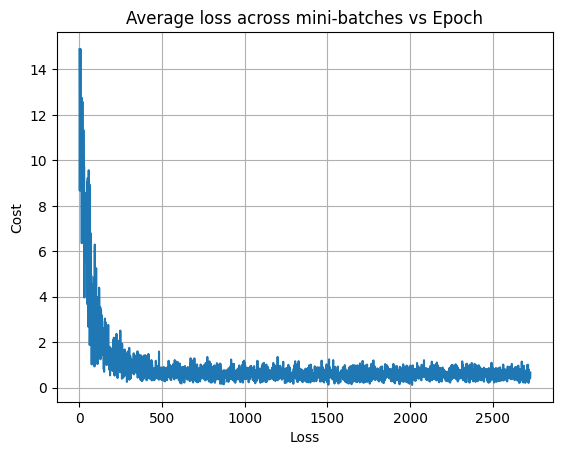

In [35]:
plt.plot(list(range(1,epoch+1)), loss_history)
plt.xlabel("Loss")
plt.ylabel("Cost")
plt.title("Average loss across mini-batches vs Epoch")
plt.grid(True)
plt.show()

In [36]:
bias, weight = updated_parameters[0].item(), updated_parameters[1].item()

Text(0.5, 0.98, 'Mini Batch Gradient Descent')

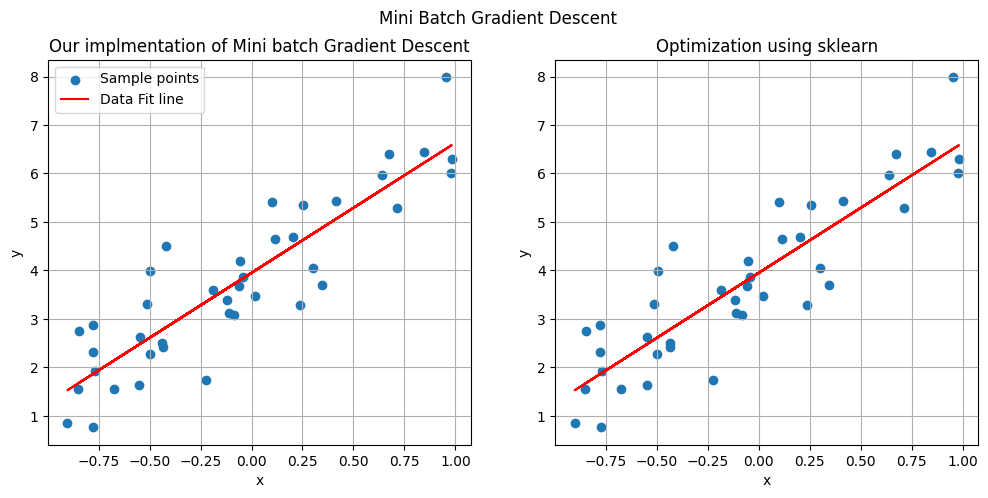

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Our plot for stochastic gradient descent
axs[0].scatter(x_new, y, label="Sample points")
axs[0].plot(x_new, x_new * weight + bias, label="Data Fit line", color='r')
axs[0].legend()
axs[0].grid(True)
axs[0].set_title('Our implementation of Mini batch Gradient Descent')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# sklearn
axs[1].scatter(x_new, y, label="Sample points")
axs[1].plot(x_new, slope * x_new + intercept, color='r', label="Fit line")
axs[1].grid(True)
axs[1].set_title('Optimization using sklearn')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.suptitle("Mini Batch Gradient Descent")

#### Average number of iterations

In [38]:
def z_score_normalize(tensor):
    mean = tensor.mean()
    std = tensor.std()
    return (tensor - mean) / std

In [39]:
x_tensor = torch.tensor(x_new, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

x_tensor = x_tensor.view(-1, 1)
y_tensor = y_tensor.view(-1, 1)


# Helper functions (the previous ones were made to work with tensors, these work with np arrays as well)
def model_prediction(x, parameters):
    x = x.reshape(-1, 1) 
    return torch.matmul(x, parameters.unsqueeze(0))

def mse_loss(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)

In [40]:
def average_iteration_calculator(x_tensor, y_tensor, gd_algo, model_prediction = model_prediction, loss_func = mse_loss):
    # x = z_score_normalize(x)
    # y = z_score_normalize(y)
    
    if gd_algo == "full-batch":
        updated_parameters, loss_history, n_iterations, epoch, param_history = full_batch_gradient_descent(x_tensor, y_tensor, epochs = 100000, learning_rate = 0.001, epsilon = 0.001, model_prediction = linear_model_prediction, loss_func = mse_loss, verbose = 0)
        
    elif gd_algo == "stochastic":
        updated_parameters, loss_history, n_iterations, cost_history, epoch, param_history = stochastic_batch_gradient_descent(x_tensor, y_tensor, epochs = 3000, learning_rate = 0.001, epsilon = 0.001, model_prediction = linear_model_prediction, loss_func = mse_loss, verbose = 0)

    elif gd_algo == "mini-batch":
        updated_parameters, loss_history, n_iterations, epoch, param_history = mini_batch_gradient_descent(x_tensor, y_tensor, epochs = 10000, learning_rate = 0.001, epsilon = 0.001, model_prediction = linear_model_prediction, loss_func = mse_loss, verbose = 0)
    return epoch, n_iterations

The below code cells take a significant amount of compute if executed

In [41]:
# # warnings.filterwarnings("ignore", category=UserWarning, module="torch")
# data_dict = {"full-batch": [[],[]], "stochastic": [[], []], "mini-batch": [[], []]}

# for i in tqdm.tqdm(range(1, 11)):
#     shuffled_indices = torch.randperm(x_tensor.size(0)) #shuffling the dataset for each iteration
#     for gd_algo in ["full-batch", "stochastic", "mini-batch"]:
#         epoch, n_iterations = average_iteration_calculator(x_tensor[shuffled_indices], y_tensor[shuffled_indices], gd_algo, model_prediction, mse_loss)
#         print(f"{gd_algo}: {epoch}, {n_iterations}")
#         data_dict[gd_algo][0].append(epoch)
#         data_dict[gd_algo][1].append(n_iterations)

# # print(data_dict)

In [42]:
# rows = []

# for algo, values in data_dict.items():
#     for epoch, n_iter in zip(values[0], values[1]):
#         rows.append({'Algorithm': algo, 'Epochs': epoch, 'Iterations': n_iter})

# df = pd.DataFrame(rows)

In [43]:
# mean_df = df.groupby('Algorithm').mean().reset_index()
# mean_df["Algorithm"] = ["Full Batch Gradient Descent", "Mini Batch Gradient Descent", "Stochastic Gradient Descent"]
# mean_df

In [44]:
# mean_df.to_csv("mean_df.csv")
# df.to_csv("df.csv")

#### Contour plots

In [45]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_contour(x, y, parameter_range, model_prediction, loss_func, gd_algo):
    # Picks up all possible points (with the given step size) in the given range 
    param_values = np.linspace(parameter_range[0], parameter_range[1], parameter_range[2])
    X, Y = np.meshgrid(param_values, param_values) 
    Z = np.zeros_like(X)

    # Computes loss over all (X, Y)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            params = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32)
            
            # Compute predictions for the entire dataset with the current parameter values
            y_pred = model_prediction(x, params)
            
            # Compute loss
            loss = loss_func(torch.tensor(y, dtype=torch.float32), y_pred).item()
            Z[i, j] = loss

    # Optimization
    if gd_algo == "full-batch":
        title = "Full Batch Gradient Descent"
        updated_parameters, loss_history, n_iterations, epoch, param_history = full_batch_gradient_descent(x, torch.tensor(y, dtype=torch.float32), epochs=15, learning_rate=0.05, epsilon=0.001, model_prediction=model_prediction, num_parameters="given", verbose=0)

        print(title)
        y_pred = model_prediction(x, updated_parameters)
        print("Mean Squared Error: ", end = "")
        print(loss_func(torch.tensor(y, dtype=torch.float32), y_pred).item())
        
    elif gd_algo == "stochastic":
        title = "Stochastic Gradient Descent"
        updated_parameters, loss_history, n_iterations, cost_history, epoch, param_history = stochastic_batch_gradient_descent(x, torch.tensor(y, dtype=torch.float32),epochs=15, learning_rate=0.01, epsilon=0.001, model_prediction=model_prediction, verbose=0)

        print(title)
        print("Mean Squared Error: ", end = "")
        y_pred = model_prediction(x, updated_parameters)
        print(loss_func(torch.tensor(y, dtype=torch.float32), y_pred).item())

    elif gd_algo == "momentum":
        title = "Gradient Descent with momentum"
        updated_parameters, loss_history, n_iterations, epoch, param_history, mometum_history, gradient_history = full_batch_gradient_descent_with_momentum(x, torch.tensor(y, dtype=torch.float32), epochs=15, learning_rate=0.05, num_parameters="given", epsilon=0.001, model_prediction=model_prediction, verbose=0) # type: ignore

        print(title)
        print("Mean Squared Error: ", end = "")
        y_pred = model_prediction(x, updated_parameters)
        print(loss_func(torch.tensor(y, dtype=torch.float32), y_pred).item())

    elif gd_algo == "mini-batch":
        title = "Mini Batch Gradient Descent"
        updated_parameters, loss_history, n_iterations, epoch, param_history = mini_batch_gradient_descent(x, torch.tensor(y, dtype=torch.float32), epochs=15, learning_rate=0.05, num_parameters= "given", epsilon=0.001, model_prediction=model_prediction, verbose=0)

        print(title)
        y_pred = model_prediction(x, updated_parameters)
        print("Mean Squared Error: ", end = "")
        print(loss_func(torch.tensor(y, dtype=torch.float32), y_pred).item())

    # Contour plot
    plt.figure()
    contour = plt.contourf(X, Y, Z, cmap='viridis')
    plt.colorbar(contour)
    plt.title(f'Loss Contour for {title}')
    plt.xlabel('Parameter 1')
    plt.ylabel('Parameter 2')

    if len(param_history) > 0:
        param_history = np.array(param_history)
        plt.scatter(param_history[:15, 0], param_history[:15, 1], color='red')
        plt.plot(param_history[:15, 0], param_history[:15, 1], color='red')
        
    plt.show()

In [46]:
# Helper functions (the previous ones were made to work with tensors, these work with np arrays as well)
def model_prediction(x, parameters):
    x = x.reshape(-1, 1) # changes the shape from (x_dim, ) to (x_dim, 1) 
    return torch.matmul(x, parameters.unsqueeze(0)) # unsqueeze adds an extra dimension to the given matrix (in our case parameters)

def mse_loss(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2) 

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6064\2556970210.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_func(torch.tensor(y, dtype=torch.float32), y_pred).item()
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6064\2556970210.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  updated_parameters, loss_history, n_iterations, epoch, param_history = full_batch_gradient_descent(x, torch.tensor(y, dtype=torch.float32), epochs=15, learning_rate=0.05, epsilon=0.001, model_prediction=model_prediction, num_parameters="given", verbose=0)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6064\2556970210.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sou

<class 'torch.Tensor'>
Full Batch Gradient Descent
Mean Squared Error: 17.149219512939453


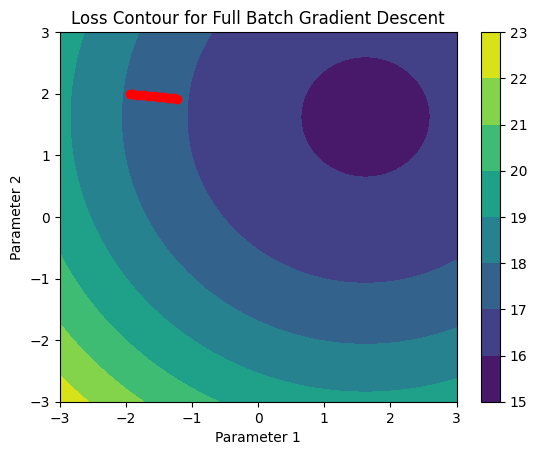

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6064\2556970210.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  updated_parameters, loss_history, n_iterations, cost_history, epoch, param_history = stochastic_batch_gradient_descent(x, torch.tensor(y, dtype=torch.float32),epochs=15, learning_rate=0.01, epsilon=0.001, model_prediction=model_prediction, verbose=0)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6064\2556970210.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(loss_func(torch.tensor(y, dtype=torch.float32), y_pred).item())


<class 'torch.Tensor'>
Stochastic Gradient Descent
Mean Squared Error: 15.867238998413086


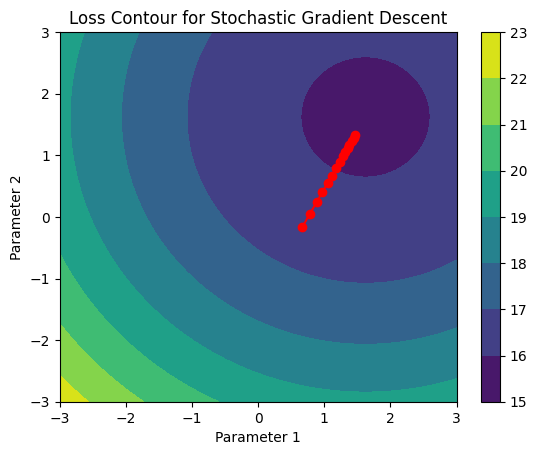

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6064\2556970210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  updated_parameters, loss_history, n_iterations, epoch, param_history = mini_batch_gradient_descent(x, torch.tensor(y, dtype=torch.float32), epochs=15, learning_rate=0.05, num_parameters= "given", epsilon=0.001, model_prediction=model_prediction, verbose=0)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6064\2556970210.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(loss_func(torch.tensor(y, dtype=torch.float32), y_pred).item())


<class 'torch.Tensor'>
Mini Batch Gradient Descent
Mean Squared Error: 16.104015350341797


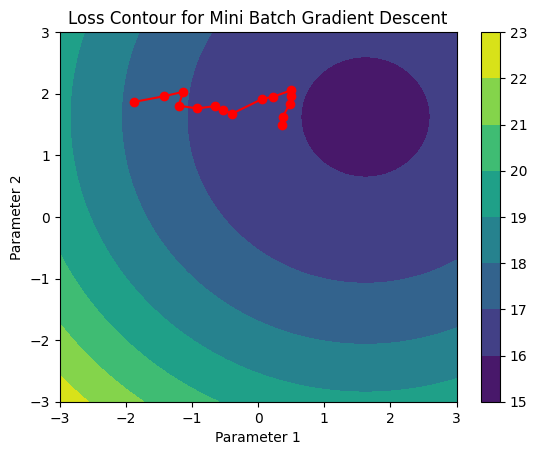

In [47]:
plot_contour(x_tensor, y_tensor, parameter_range=(-3, 3, 100), model_prediction = model_prediction, loss_func = mse_loss, gd_algo = "full-batch")
print()
plot_contour(x_tensor, y_tensor, parameter_range=(-3, 3, 100), model_prediction = model_prediction, loss_func = mse_loss, gd_algo = "stochastic")
print()
plot_contour(x_tensor, y_tensor, parameter_range=(-3, 3, 100), model_prediction = model_prediction, loss_func = mse_loss, gd_algo = "mini-batch")

### Task 1d

Explore the article [here](https://machinelearningmastery.com/gradient-descent-with-momentum-from-scratch/#:~:text=Momentum%20is%20an%20extension%20to,spots%20of%20the%20search%20space.) on gradient descent with momentum. Implement gradient descent with momentum for the dataset. Visualize the convergence process for 15 steps. Compa   re the average number of steps taken with gradient descent (for variants full batch and stochastic) with momentum to that of vanilla gradient descent to converge to an $\epsilon$-neighborhood for both dataset. Choose $\epsilon = 0.001$. Write down your observations. Show the contour plots for different epochs for momentum implementation. Specifically, show all the vectors: gradient, current value of theta, momentum, etc.

In [48]:
def linear_model_prediction(x, parameters):
    bias, weight = parameters
    return bias + weight * x

def mse_loss(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)

In [49]:
def full_batch_gradient_descent_with_momentum(x, y, epochs = 15, learning_rate = 0.01, epsilon = 0.001, momentum = 0.9, model_prediction = linear_model_prediction, loss_func = mse_loss, num_parameters = "given", verbose = 1):
    """
    Perform full batch gradient descent on the given dataset by random initialization and applies momentum to smoothen the optimization path
    """

    if num_parameters == "given":
        parameters = torch.nn.Parameter(torch.tensor([-3.0, 3.0], dtype=torch.float32))
    else:
        parameters = torch.nn.Parameter(torch.randn(num_parameters, dtype=torch.float32))
    
    theta_optimal = normal_equation_solver(x, y).view(-1)
    loss_history = []
    param_history = []
    momentum_history = []
    gradient_history = []
    parameters.requires_grad_(True)
    n_iterations = 0
    
    # Initializing velocity vector
    velocity = torch.zeros_like(parameters)
    
    for epoch in range(epochs):        
        if epoch > 0:
            parameters.grad.zero_()
        
        # Forward prop
        y_pred = model_prediction(x, parameters)
        loss = loss_func(y, y_pred)
        loss_history.append(loss.item())
        
        # Backprop
        loss.backward()
        
        # Updating the velocity vector and the parameters
        with torch.no_grad():
            velocity = momentum * velocity + learning_rate * parameters.grad
            # parameters.grad /= torch.norm(parameters.grad)
            parameters -= velocity

        n_iterations += 1
        
        param_history.append([parameters[i].item() for i in range(len(parameters))])
        momentum_history.append([velocity[i].item() for i in range(len(parameters))])
        gradient_history.append([parameters.grad[i].item() for i in range(len(parameters))])
        
        param_diff = torch.norm(parameters - theta_optimal)
        if verbose:
            print(f"Epoch: {epoch + 1} ---> Loss = {loss.item()}")
            # print(f"Parameter Gradients: {parameters.grad}")
            # print(f"Parameter Difference: {param_diff.item()}")
            # print(f"Velocity: {velocity}")
        
        # Convergence check
        # print(param_diff.item() <= epsilon)
        if param_diff.item() <= epsilon:
            print(f"Convergence reached after {epoch + 1} epochs. Parameter difference: {param_diff.item()}")
            break
    
    return parameters, loss_history, n_iterations, epoch + 1, param_history, momentum_history, gradient_history

In [50]:
updated_parameters, loss_history, n_iterations, epoch, param_history, momentum_history, gradient_history = full_batch_gradient_descent_with_momentum(x_tensor, y_tensor, epochs = 10000, learning_rate = 0.1, momentum = 0, epsilon = 0.001, model_prediction = linear_model_prediction, loss_func = mse_loss, verbose = 1)

<class 'torch.Tensor'>
Epoch: 1 ---> Loss = 49.31375503540039
Epoch: 2 ---> Loss = 31.635183334350586
Epoch: 3 ---> Loss = 20.37679672241211
Epoch: 4 ---> Loss = 13.206425666809082
Epoch: 5 ---> Loss = 8.639147758483887
Epoch: 6 ---> Loss = 5.729484558105469
Epoch: 7 ---> Loss = 3.8754215240478516
Epoch: 8 ---> Loss = 2.693634510040283
Epoch: 9 ---> Loss = 1.9400402307510376
Epoch: 10 ---> Loss = 1.4592124223709106
Epoch: 11 ---> Loss = 1.1521748304367065
Epoch: 12 ---> Loss = 0.9558956027030945
Epoch: 13 ---> Loss = 0.8302294015884399
Epoch: 14 ---> Loss = 0.7496048212051392
Epoch: 15 ---> Loss = 0.697731077671051
Epoch: 16 ---> Loss = 0.6642266511917114
Epoch: 17 ---> Loss = 0.6424745321273804
Epoch: 18 ---> Loss = 0.6282548904418945
Epoch: 19 ---> Loss = 0.6188750267028809
Epoch: 20 ---> Loss = 0.6126152276992798
Epoch: 21 ---> Loss = 0.608376145362854
Epoch: 22 ---> Loss = 0.6054536700248718
Epoch: 23 ---> Loss = 0.6033957600593567
Epoch: 24 ---> Loss = 0.6019118428230286
Epoch: 25

Text(0.5, 0.98, 'Stochastic Gradient Descent')

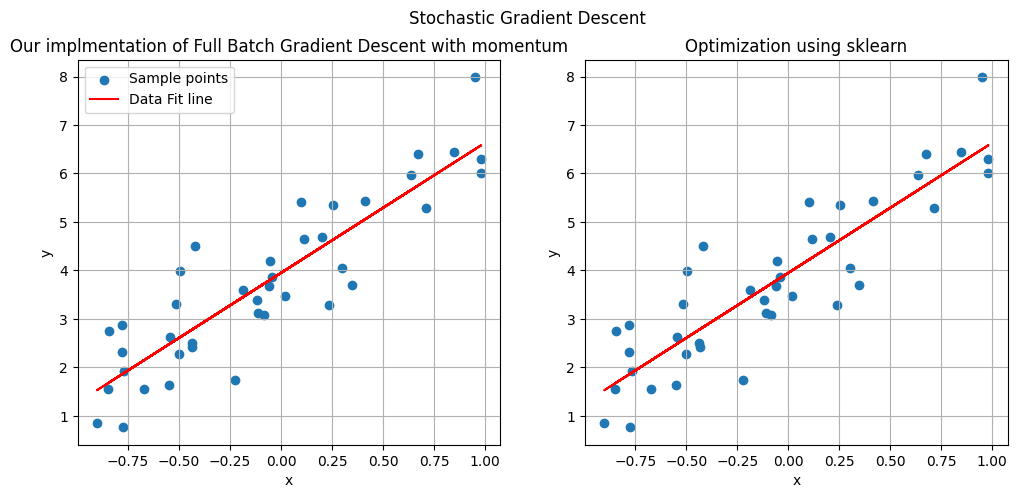

In [51]:
bias, weight = updated_parameters[0].item(), updated_parameters[1].item()
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Our plot for stochastic gradient descent
axs[0].scatter(x_new, y, label="Sample points")
axs[0].plot(x_new, x_new * weight + bias, label="Data Fit line", color='r')
axs[0].legend()
axs[0].grid(True)
axs[0].set_title('Our implementation of Full Batch Gradient Descent with momentum')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# sklearn
axs[1].scatter(x_new, y, label="Sample points")
axs[1].plot(x_new, slope * x_new + intercept, color='r', label="Fit line")
axs[1].grid(True)
axs[1].set_title('Optimization using sklearn')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.suptitle("Stochastic Gradient Descent")

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6064\2556970210.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_func(torch.tensor(y, dtype=torch.float32), y_pred).item()
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6064\2556970210.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  updated_parameters, loss_history, n_iterations, epoch, param_history, mometum_history, gradient_history = full_batch_gradient_descent_with_momentum(x, torch.tensor(y, dtype=torch.float32), epochs=15, learning_rate=0.05, num_parameters="given", epsilon=0.001, model_prediction=model_prediction, verbose=0) # type: ignore
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6064\2556970210.py:49: UserWarnin

<class 'torch.Tensor'>
Gradient Descent with momentum
Mean Squared Error: 0.8037206530570984


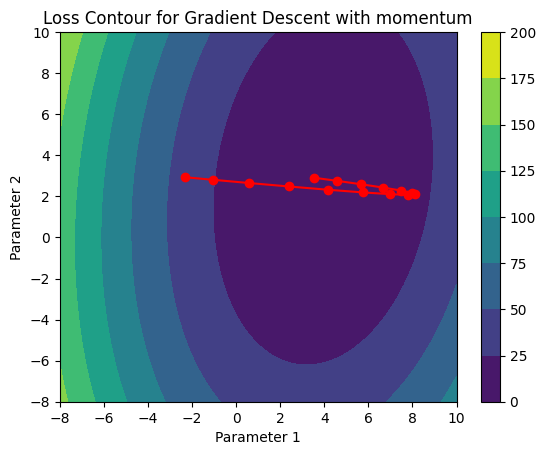

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6064\2556970210.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  updated_parameters, loss_history, n_iterations, epoch, param_history = full_batch_gradient_descent(x, torch.tensor(y, dtype=torch.float32), epochs=15, learning_rate=0.05, epsilon=0.001, model_prediction=model_prediction, num_parameters="given", verbose=0)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6064\2556970210.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(loss_func(torch.tensor(y, dtype=torch.float32), y_pred).item())


<class 'torch.Tensor'>
Full Batch Gradient Descent
Mean Squared Error: 17.149219512939453


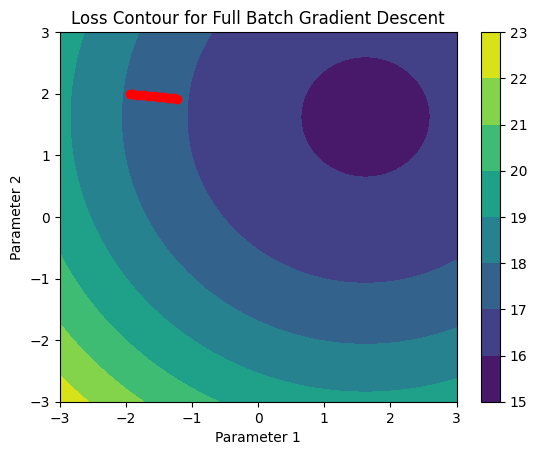

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6064\2556970210.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  updated_parameters, loss_history, n_iterations, cost_history, epoch, param_history = stochastic_batch_gradient_descent(x, torch.tensor(y, dtype=torch.float32),epochs=15, learning_rate=0.01, epsilon=0.001, model_prediction=model_prediction, verbose=0)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6064\2556970210.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(loss_func(torch.tensor(y, dtype=torch.float32), y_pred).item())


<class 'torch.Tensor'>
Stochastic Gradient Descent
Mean Squared Error: 15.862805366516113


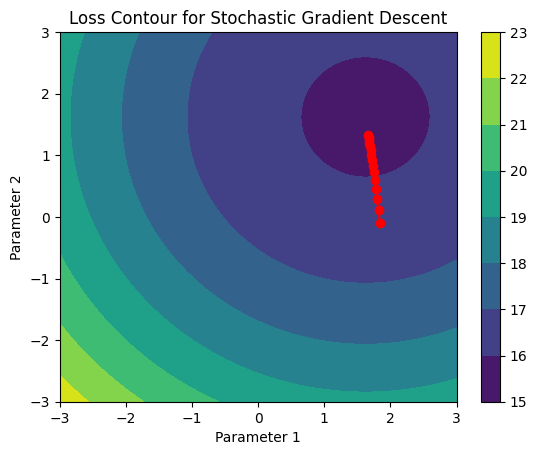

In [52]:
plot_contour(x_tensor, y_tensor, parameter_range=(-8, 10, 100), model_prediction = linear_model_prediction, loss_func = mse_loss, gd_algo = "momentum")
print()
plot_contour(x_tensor, y_tensor, parameter_range=(-3, 3, 100), model_prediction = model_prediction, loss_func = mse_loss, gd_algo = "full-batch")
print()
plot_contour(x_tensor, y_tensor, parameter_range=(-3, 3, 100), model_prediction = model_prediction, loss_func = mse_loss, gd_algo = "stochastic")
print()

In [53]:
selected_epoch = widgets.IntSlider(
    value = 1,
    min = 1,
    max = epoch,
    step = 1,
    description = 'Epoch:',
    disabled = False,
    continuous_update = False,
    orientation = 'horizontal',
    readout = True,
    readout_format = 'd'
)


In [54]:
def plot_momentum_contour(x, y, user_selected_epoch, parameter_range, model_prediction = model_prediction, loss_func = mse_loss):
    param_values = np.linspace(parameter_range[0], parameter_range[1], parameter_range[2])
    X, Y = np.meshgrid(param_values, param_values) 
    Z = np.zeros_like(X)

    # Computes loss over all (X, Y)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            params = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32)
            
            # Compute predictions for the entire dataset with the current parameter values
            y_pred = model_prediction(x, params)
            
            # Compute loss
            loss = loss_func(torch.tensor(y, dtype=torch.float32), y_pred).item()
            Z[i, j] = loss

    title = f"Gradient Descent with momentum ({user_selected_epoch}th epoch)"
    updated_parameters, _, _, _, param_history, momentum_history, gradient_history = full_batch_gradient_descent_with_momentum(x, torch.tensor(y, dtype=torch.float32), epochs = 1000, learning_rate=0.001, num_parameters="given", epsilon=0.001, model_prediction=model_prediction, verbose=0)

    print(title)
    print("Mean Squared Error: ", end = "")
    y_pred = model_prediction(x, updated_parameters)
    print(loss_func(torch.tensor(y, dtype=torch.float32), y_pred).item())

    # Plotting
    plt.figure()
    contour = plt.contourf(X, Y, Z, cmap='viridis')
    plt.colorbar(contour)
    plt.title(f'Loss Contour for {title}')
    plt.xlabel('Parameter 1')
    plt.ylabel('Parameter 2')

    if len(param_history) > 0:
        param_history = np.array(param_history)
        plt.scatter(param_history[:user_selected_epoch, 0], param_history[:user_selected_epoch, 1], color='red')
        plt.plot(param_history[:user_selected_epoch, 0], param_history[:user_selected_epoch, 1], color='red')
        # TODO: plot momentum vector for that epoch
        plt.arrow(param_history[user_selected_epoch][0], param_history[user_selected_epoch][1], momentum_history[user_selected_epoch][0], momentum_history[user_selected_epoch][1], head_width = 0.1, head_length = 0.05, fc = 'blue', ec = 'blue', alpha = 0.5, label = "Momentum Vector")
        
        plt.arrow(param_history[user_selected_epoch][0], param_history[user_selected_epoch][1], gradient_history[user_selected_epoch][0], gradient_history[user_selected_epoch][1], head_width = 0.2, head_length = 0.1, fc = 'cyan', ec = 'cyan', alpha = 0.5, label = "Gradient Vector")
        
        plt.legend()
        
    plt.show()

IntSlider(value=1, continuous_update=False, description='Epoch:', min=1)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6064\1643582548.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_func(torch.tensor(y, dtype=torch.float32), y_pred).item()
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6064\1643582548.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  updated_parameters, _, _, _, param_history, momentum_history, gradient_history = full_batch_gradient_descent_with_momentum(x, torch.tensor(y, dtype=torch.float32), epochs = 1000, learning_rate=0.001, num_parameters="given", epsilon=0.001, model_prediction=model_prediction, verbose=0)


<class 'torch.Tensor'>
Gradient Descent with momentum (45th epoch)
Mean Squared Error: 15.855158805847168


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6064\1643582548.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(loss_func(torch.tensor(y, dtype=torch.float32), y_pred).item())


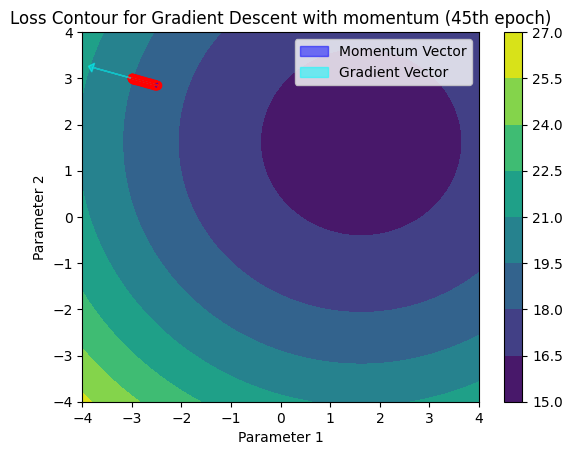

In [55]:
display(selected_epoch)
# you can use the slider below or directly input the value below to choose an epoch
user_selected_epoch = selected_epoch.value - 1
user_selected_epoch = 45

plot_momentum_contour(x_tensor, y_tensor, user_selected_epoch, parameter_range=(-4, 4, 100))

##### Observations

The method of Gradient Descent with momentum seems to converge in ```lesser epochs``` than vanilla Gradient Descent. <br>
<br>
We also expect a ```smoother optimization path``` than the vanilla version of the optimization algorithm but this was not so in our case because of reasons such as limited data size and due to the criteria that we use to declare convergence (this criteria is not an ideal one because if we have already obtained the optimal parameters by the normal equation than there is no point in trying to re-optimize using gradient descent) <br>
<br>
We get a smoother optimization path because of the fact that the momentum algorithm is using a kind of a moving average of gradients in order to update the parameters which reduces the noise that a non-momentum algorithm might induce during optimization 